In [1]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.datasets import fetch_20newsgroups
from pprint import pprint
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from sklearn.decomposition import LatentDirichletAllocation as LDA
from sklearn.decomposition import NMF

'''
!!!!!!!!
'''
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Linking words to topics
def word_topic(tfidf,solution, wordlist):
    
    # Loading scores for each word on each topic/component.
    words_by_topic=tfidf.T * solution

    # Linking the loadings to the words in an easy-to-read way.
    components=pd.DataFrame(words_by_topic,index=wordlist)
    
    return components

# Extracts the top N words and their loadings for each topic.
def top_words(components, n_top_words):
    n_topics = range(components.shape[1])
    index= np.repeat(n_topics, n_top_words, axis=0)
    topwords=pd.Series(index=index)
    for column in range(components.shape[1]):
        # Sort the column so that highest loadings are at the top.
        sortedwords=components.iloc[:,column].sort_values(ascending=False)
        # Choose the N highest loadings.
        chosen=sortedwords[:n_top_words]
        # Combine loading and index into a string.
        chosenlist=chosen.index +" "+round(chosen,2).map(str) 
        topwords.loc[column]=chosenlist
    return(topwords)

# Number of words to look at for each topic.
n_top_words = 3



alt.atheism
           LSA           LDA         NNMF
0     god 9.92    tiger 0.55  people 1.06
0  people 9.31  germany 0.52   think 1.02
0      don 9.2     irony 0.5      don 1.0
['god', 'people', 'don', 'tiger', 'germany', 'irony', 'think']


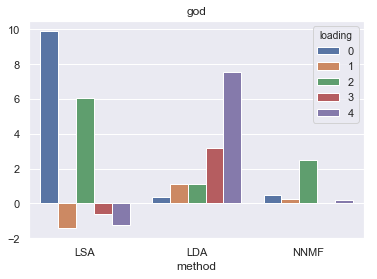

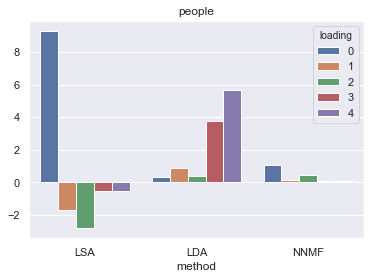

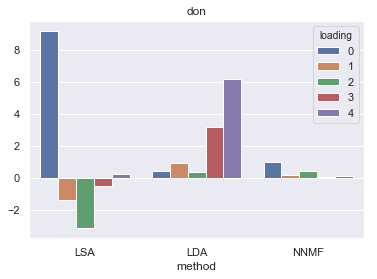

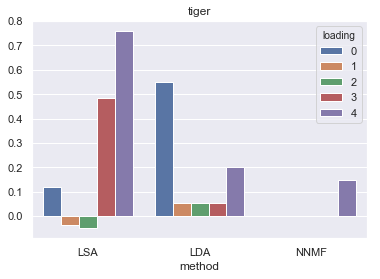

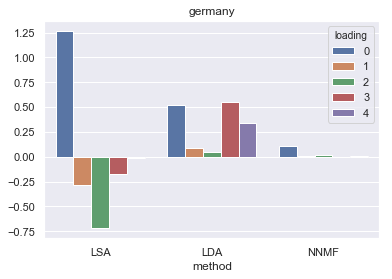

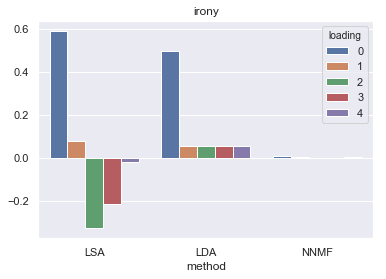

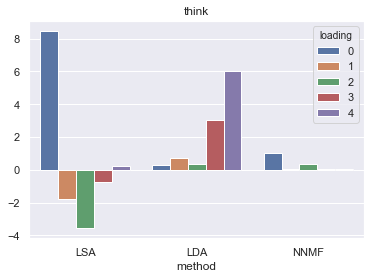


sci.space
           LSA          LDA        NNMF
0  space 15.27  space 17.23   like 0.71
0    like 8.03    like 8.97  space 0.67
0    nasa 7.29    nasa 8.86   just 0.63
['space', 'like', 'nasa', 'just']


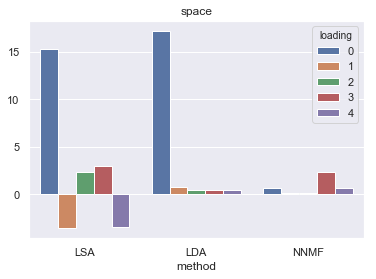

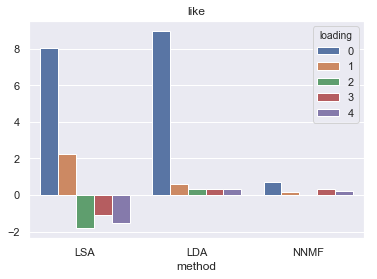

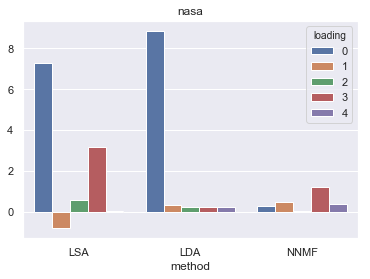

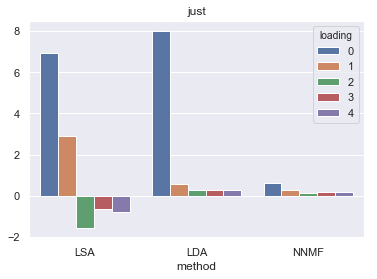

In [3]:
categories = ['alt.atheism', 'sci.space']

#categories = ['alt.atheism', 'talk.religion.misc',
#               'comp.graphics', 'sci.space']
for category in categories:
    print ('\n'+category)
    newsgroups_train = fetch_20newsgroups(subset='train', 
                                          categories=[category],
                                          remove=('headers',
                                                  'footers',
                                                  'quotes'))

    vectorizer = TfidfVectorizer(stop_words='english')
    vectors = vectorizer.fit_transform(newsgroups_train.data)
    terms = vectorizer.get_feature_names()
    ntopics=5

    # LSA
    svd= TruncatedSVD(ntopics)
    lsa = make_pipeline(svd, Normalizer(copy=False))
    vectors_lsa = lsa.fit_transform(vectors)
    components_lsa = word_topic(vectors, vectors_lsa, terms)
    topwords=pd.DataFrame()
    topwords['LSA']=top_words(components_lsa, n_top_words)

    # LDA
    lda = LDA(n_topics=ntopics, 
              doc_topic_prior=None, # Prior = 1/n_documents
              topic_word_prior=1/ntopics,
              learning_decay=0.7, # Convergence rate.
              learning_offset=10.0, # Causes earlier iterations to have less influence on the learning
              max_iter=10, # when to stop even if the model is not converging (to prevent running forever)
              evaluate_every=-1, # Do not evaluate perplexity, as it slows training time.
              mean_change_tol=0.001, # Stop updating the document topic distribution in the E-step when mean change is < tol
              max_doc_update_iter=100, # When to stop updating the document topic distribution in the E-step even if tol is not reached
              n_jobs=-1, # Use all available CPUs to speed up processing time.
              verbose=0, # amount of output to give while iterating
              random_state=0
             )
    vectors_lda = lda.fit_transform(vectors) 
    components_lda = word_topic(vectors, vectors_lda, terms)
    topwords['LDA']=top_words(components_lda, n_top_words)

    # NNMF
    nmf = NMF(alpha=0.0, 
              init='nndsvdar', # how starting value are calculated
              l1_ratio=0.0, # Sets whether regularization is L2 (0), L1 (1), or a combination (values between 0 and 1)
              max_iter=200, # when to stop even if the model is not converging (to prevent running forever)
              n_components=ntopics, 
              random_state=0, 
              solver='cd', # Use Coordinate Descent to solve
              tol=0.0001, # model will stop if tfidf-WH <= tol
              verbose=0 # amount of output to give while iterating
             )
    vectors_nmf = nmf.fit_transform(vectors) 
    components_nmf = word_topic(vectors, vectors_nmf, terms)
    topwords['NNMF']=top_words(components_nmf, n_top_words)
    print(topwords.loc[0])
    
    targetwords = []
    for column in topwords:
        twRdx = topwords[column].reset_index(drop=True)
        for index, i in enumerate(twRdx):
            if index == n_top_words:
                break;
            wrd = str.split(i)[0]
            if wrd not in targetwords:
                targetwords.append(wrd)
    print (targetwords)            

    # Storing the loadings.
    wordloadings=pd.DataFrame(columns=targetwords)

    # For each word, extracting and string the loadings for each method.
    for word in targetwords:
        loadings=components_lsa.loc[word].append(
            components_lda.loc[word]).append(
                components_nmf.loc[word])
        wordloadings[word]=loadings

    # Labeling the data by method and providing an ordering variable for graphing purposes. 
    wordloadings['method']=np.repeat(['LSA','LDA','NNMF'], 5, axis=0)
    wordloadings['loading']=[0,1,2,3,4]*3
    #wordloadings['method']=np.repeat(['LSA','NNMF'], 5, axis=0)
    #wordloadings['loading']=[0,1,2,3,4]*2

    sns.set(style="darkgrid")

    for word in targetwords:
        sns.barplot(x="method", y=word, hue="loading", data=wordloadings)
        plt.title(word)
        plt.ylabel("")
        plt.show()
